# Example 1: What price should I sell my used iphone for?
* This exmaple is taken from  http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/

### Task
* Decide for price for a phone from 2014 without scratches

### Todo:
* Excurs to shared variables in pymc3
* Make contour plots and refine the problem

In [7]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from matplotlib import pyplot as plt
from functools import partial
from scipy.special import expit
from scipy.optimize import minimize_scalar
import pymc3 as pm
% matplotlib inline

In [8]:
train = pd.DataFrame({"sold": [1, 1, 0, 0, 1, 1], 
                     "scratched": [0, 0, 1, 0, 0, 0], 
                     "year": [2014, 2015, 2010, 2014, 2015, 2016],
                     "price": [50, 70, 40, 100, 90, 100]})

### The model
$$y_{\text{sold}, i} \sim \text{Bernoulli}(\pi_i)$$
$$\pi_i \sim \text{logit}^{-1}(\eta_i)$$
$$\eta_i \sim \beta_0 + \beta_1 \text{scratched}_i + \beta_2 \text{year_i} + \beta_3 \text{price}_i$$

### Priors
$$\beta_0 \sim \text{Uniform}$$
$$\beta_1 \sim \mathcal N(-1, 1)$$
$$\beta_2 \sim \mathcal N(1, 1) $$
$$\beta_3 \sim \mathcal N(-2, 1) $$


### Utility function
* We need to decide at what price we would like to sell the phone
* So the price is our decision space
* $$U(price, \pi) = price \, \pi$$

### Expected utility function
$$ U(price) = \left \langle U(price, \pi)  \right \rangle _ {p(\pi)}$$



### Next Steps
* Instead of year take feature "years old"
* Include interaction terms
* Use GLM syntax

In [31]:
def get_intial_test_values(model: pm.Model):
    for RV in model.basic_RVs:
        print(RV.name, RV.logp(model.test_point))

def inspect_model(trace):
    pm.traceplot(trace)
    print(pm.summary(trace))
    
    

In [23]:
with pm.Model() as logistic:
    Intercept = pm.Uniform("Intercept", -7000, -1000)
    scratched = pm.Normal("scratched", mu=-1, sd=1)
    year = pm.Normal("year", mu=1, sd=1)    
    price = pm.Normal("price", mu=-2, sd=1) 
    pi = pm.math.invlogit(Intercept + scratched * train.scratched + year * train.year + price * train.price)
    likelihood = pm.Bernoulli('likelihood', pi, observed=train.sold)
    trace_logistic = pm.sample(chains=1, tune=1000, samples=2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [price, year, scratched, Intercept_interval__]
INFO:pymc3:NUTS: [price, year, scratched, Intercept_interval__]
100%|██████████| 1500/1500 [01:54<00:00, 13.06it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


                  mean           sd    mc_error      hpd_2.5     hpd_97.5
scratched    -1.503398     0.836487    0.077024    -3.533393    -0.169910
year          2.053806     0.584001    0.056027     1.000001     3.279535
price        -0.120551     0.066749    0.006128    -0.247756    -0.001498
Intercept -4125.635399  1173.133145  112.521948 -6590.651170 -2004.315896


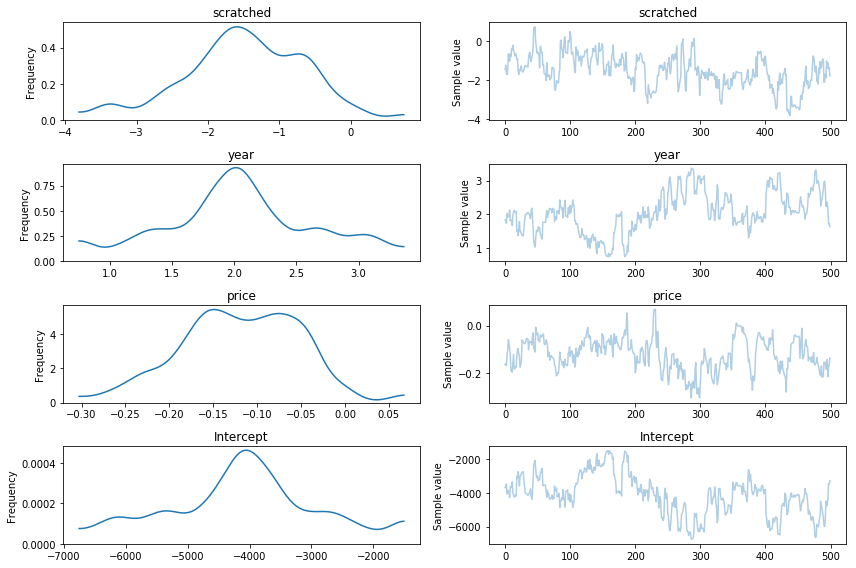

In [32]:
inspect_model(trace_logistic)

In [34]:
def predict(price, scratched, year, trace):
    linear = trace['Intercept'] + trace['scratched'] * scratched + trace['year'] * year + trace['price'] * price
    return expit(linear)

# probabilities for given phone
buy_probability = partial(predict, trace=trace_logistic, scratched=0, year=2014)

# expected utility function
expected_utility = lambda price: price.flatten() * buy_probability(price).mean(axis=1)

# Numerical optimum
optimum = minimize_scalar(lambda x: -expected_utility(np.array([[x]])).flatten()[0])['x']

** First we habe a quick look at the pdf relevant pdf

Text(0.5,0,'price')

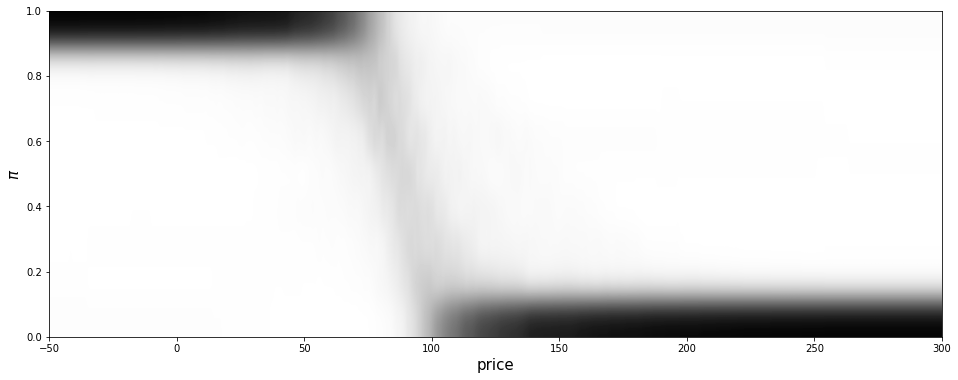

In [35]:
prices = np.arange(-50, 300)
bins = np.linspace(0, 1, 10, endpoint=True)
pis = bins[1:]
pdf = np.zeros((len(prices), len(pis)))
for p in range(len(prices)):
    hist, _ = np.histogram(buy_probability(prices[p]), bins=bins)
    pdf[p, :] = hist
X, Y = np.meshgrid(prices, pis)
fig, ax = plt.subplots(figsize=(16,6))
ax.imshow(pdf.transpose(), 
          interpolation='gaussian', 
          cmap=plt.cm.binary,
          aspect='auto', 
          origin='lower', 
          extent=(-50, 300, 0, 1), 
          vmax=pdf.max(), 
          vmin=0)
ax.set_ylabel(r"$\pi$", fontsize=15)
ax.set_xlabel(r"price", fontsize=15)

* Instead of the pdf we typically consider only point estimates (mean. interquartil distances etc) for visualization

* Furthermore, we can incorporate the utility function and find it's optimum

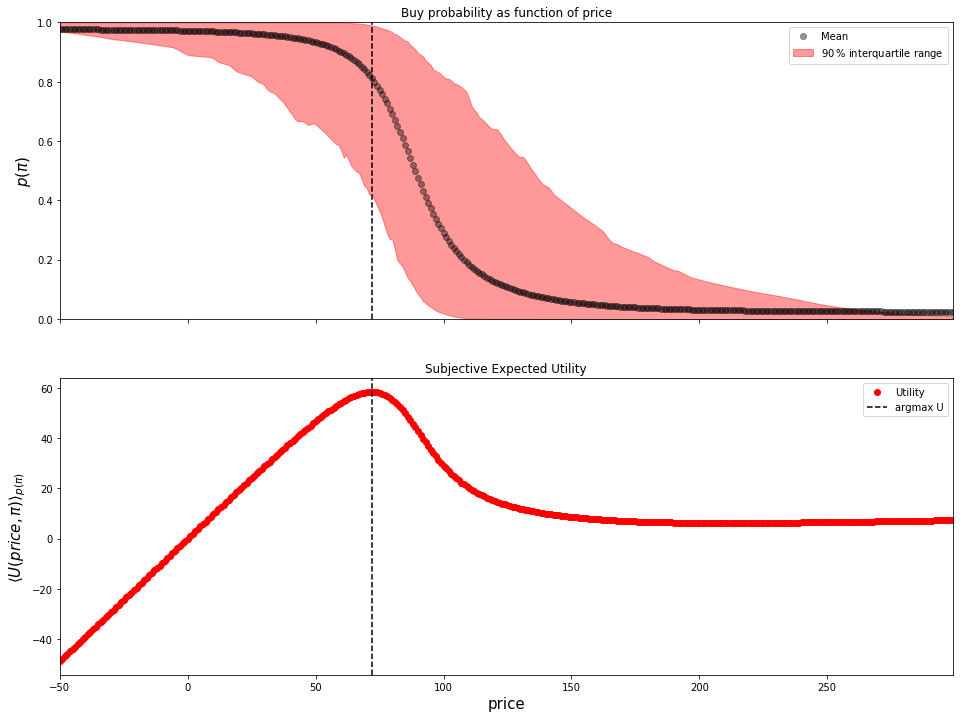

In [36]:
import numpy as np
prices = np.arange(-50, 300)[:,None]
probs = buy_probability(prices)
fig, ax = plt.subplots(nrows=2, figsize=(16,12), sharex=True)
ax[0].plot(prices, probs.mean(axis=1), 'o', color='black', alpha=0.4, label="Mean")
ax[0].fill_between(prices.flatten(), 
                np.percentile(probs, 5, axis=1), 
                np.percentile(probs, 95, axis=1), 
                color='red', 
                alpha=.4, 
                label=r"$90\,\%$ interquartile range")
ax[0].axvline(optimum, ls="--", color="black")
ax[0].set_ylabel(r"$p(\pi) $", fontsize=15)
ax[0].set_title("Buy probability as function of price")
ax[0].set_xlim(prices.min(), prices.max())
ax[0].set_ylim(0,1)
ax[0].legend()
ax[1].plot(prices, expected_utility(prices), "o", color="red", label="Utility")
ax[1].axvline(optimum, ls="--", color="black", label="argmax U")

ax[1].set_title("Subjective Expected Utility")
ax[1].set_ylabel(r"$\left \langle U(price, \pi)\right\rangle_{p(\pi)}$", fontsize=15)
ax[1].set_xlabel("price",  fontsize=15)
ax[1].legend();

# Example 2: Shall I take the bus?

### The problem:
* Assume that you need to go to work. You could either take the bus right in front of your door, or take the bike. 
* The bus ride takes 10 mins, whereas you need 15 mins by bike.
* Since you are not a native early bird, you don't have any knowledge about the bus schedule - but you do have some data for bus waiting times (which you collected)
* Now, you need to decide if to wait for the bus or to take the bike. 
* Since we live in the new work era, assume that the time you spent for going to work just corresponds to the amount of money you would have earned (assuming that you earn 1 dollar per minute). The bus ride costs you 3 $ but riding your bike is free

### Data generating process
* Let's play god for a while and assume that the waiting time corresponds to an exponential distribution with expectation time of 10 mins

### First simple approach



In [37]:
def generate_waiting_times(mean: float, size):
    return pd.DataFrame({'waiting_time': np.round(np.random.exponential(scale=mean, size=size))})

In [45]:
waiting_times = generate_waiting_times(10, 1000)

In [46]:
with pm.Model() as exponential_model:
    scale = pm.Uniform('scale', upper=30, lower=3)
    waiting_time = pm.Exponential("waiting_time", 1/scale, observed=waiting_times.waiting_time)
    exponential_model_trace = pm.sample()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [scale_interval__]
INFO:pymc3:NUTS: [scale_interval__]
100%|██████████| 1000/1000 [00:00<00:00, 2089.42it/s]


           mean        sd  mc_error   hpd_2.5   hpd_97.5       n_eff      Rhat
scale  9.513515  0.294121  0.013445  8.889969  10.033618  417.232159  0.999877


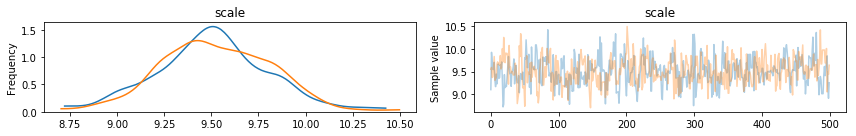

In [47]:
inspect_model(exponential_model_trace)